In [1]:
import pennylane as qml
import numpy as np
import jax.numpy as jnp
import jax

jax.config.update("jax_enable_x64", True)

import matplotlib.pyplot as plt

# download dataset for exact energy, alternatively just use E_exact = -2.166386984981435
bond_distance = 1.0
dataset = qml.data.load("qchem", molname="H4", basis="STO-3G", bondlength=bond_distance)[0]
E_exact = dataset.fci_energy

In [2]:
seeds = tuple(range(16))
n_epochs = 300
tbins = 10

hyper_params = [(seeds[i], 0.05, n_epochs) for i in range(len(seeds))]

In [3]:
energy_jax = np.zeros((16, 300))
energy_ps = np.zeros((2, 16, 300))
for i, hyp in enumerate(hyper_params):
    seed, lr, n_epochs = hyp
    name = f"data/VQE2_partial_H4_JAX-{seed}-lr-0.05-tbins-10_n-epochs-300"
    dat = np.load(name + ".npz", allow_pickle=True)
    energy_jax[i] = dat["energy"]

    name = f"data/VQE2_partial_H4_SPS-{seed}-lr-0.05-tbins-10_n-epochs-300-num-splits-8"
    dat = np.load(name + ".npz", allow_pickle=True)
    energy_ps[0, i] = dat["energy"]

    name = f"data/VQE2_partial_H4_SPS-{seed}-lr-0.05-tbins-10_n-epochs-300-num-splits-20"
    dat = np.load(name + ".npz", allow_pickle=True)
    energy_ps[1, i] = dat["energy"]

energy_jax = energy_jax - E_exact
energy_ps = energy_ps - E_exact

y_ps_var = np.std(energy_ps, axis=1)
y_ps_mean = np.mean(energy_ps, axis=1)
y_jax_var = np.std(energy_jax, axis=0)
y_jax_mean = np.mean(energy_jax, axis=0)

lower_percentile_ps = np.percentile(energy_ps, 5, axis=1)  # 5th percentile (90% below)
upper_percentile_ps = np.percentile(energy_ps, 95, axis=1)  # 95th percentile (90% above)

lower_percentile_jax = np.percentile(energy_jax, 5, axis=0)  # 5th percentile (90% below)
upper_percentile_jax = np.percentile(energy_jax, 95, axis=0)  # 95th percentile (90% above)

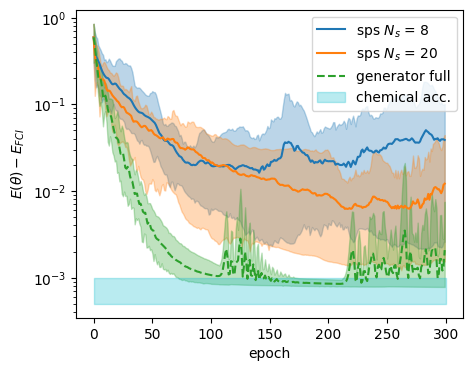

In [4]:
color = ["tab:blue", "tab:orange", "tab:green", "tab:cyan", "tab:pink"]


fig, ax = plt.subplots(figsize=(5,4))
x = np.arange(300)
n_splits = [8, 20]
for i, n_split in enumerate(n_splits):
    ax.plot(x, y_ps_mean[i], label=f"sps $N_s$ = {n_split}", color=color[i])
    ax.fill_between(x, lower_percentile_ps[i], upper_percentile_ps[i], alpha=0.3, color=color[i])

ax.plot(x, y_jax_mean[x], "--", label="generator full", color=color[2])
ax.fill_between(x, lower_percentile_jax[x], upper_percentile_jax[x], alpha=0.3, color=color[2])
ax.fill_between([0, 300], 1e-3, 0.5e-3, alpha=0.3, color=color[3], label="chemical acc.")
# ax.hlines([- dataset.fci_energy + dataset.vqe_energy], 0, 300, color=color[-1])

ax.legend(loc=0)
ax.set_ylabel("$E(\\theta) - E_{{FCI}}$")
ax.set_xlabel("epoch")
ax.set_yscale("log")

In [5]:
# minimum energy over all runs ; VQE energy of original circuit ; minimum energy on average
np.min(energy_jax) + dataset.fci_energy, dataset.vqe_energy, np.min(y_jax_mean)+ dataset.fci_energy

(-2.1656098909097263, -2.16553410190185, -2.1655401213546033)

## details

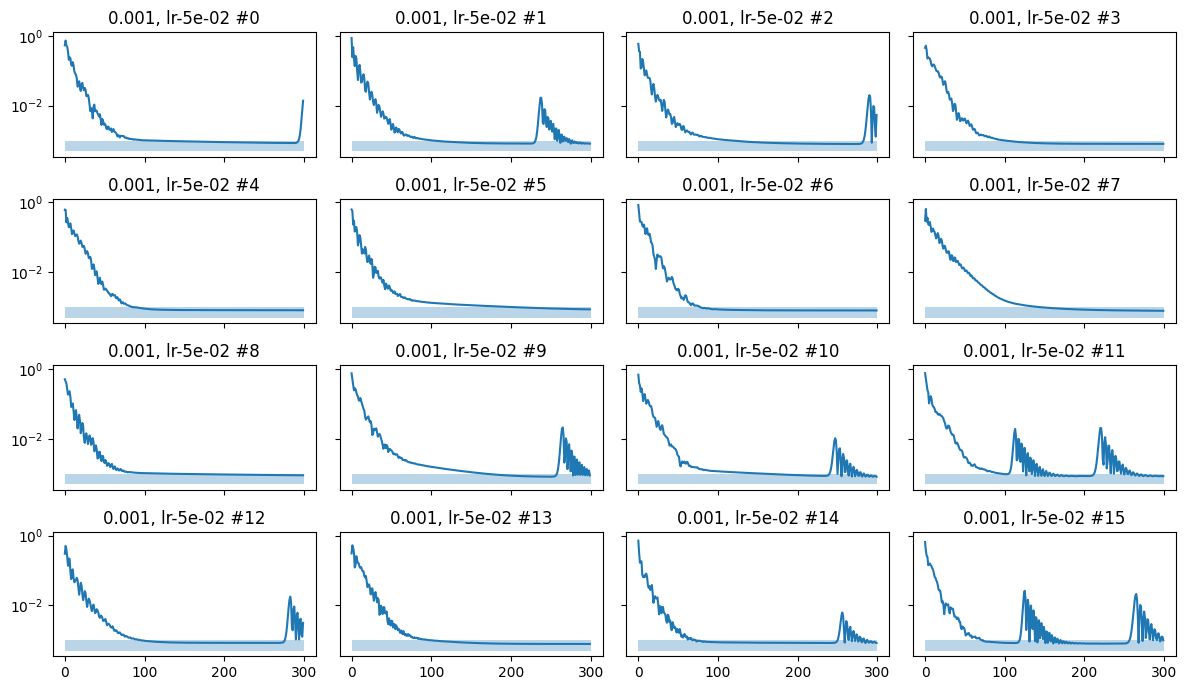

In [6]:
ncols = 4
fig, axs = plt.subplots(ncols=ncols, nrows=4, figsize=(12,7), sharey=True, sharex=True)

# axs[0, 0].text(10, 1e-2, f"T_CR {T_CR} T_single {T_single}")
# axs[0, 0].text(10, 10**(-2.5), f"n_params {n_params} tbins {tbins}")

for i,hyp in enumerate(hyper_params):
    seed, lr, _ = hyp
    name = f"data/VQE2_partial_H4_JAX-{seed}-lr-0.05-tbins-10_n-epochs-300"
    data = np.load(name + ".npz", allow_pickle=True)
    energy, thetaf = data["energy"], data["theta"]
    energy -= E_exact
    emin = np.min(energy)

    ax = axs[i//ncols, i%ncols]
    ax.plot(energy)
    # ax.hlines([E_vqe - E_exact], 0, 300)
    ax.fill_between([0, 300], 1e-3, 0.5e-3, alpha=0.3)
    
    ax.set_yscale("log")
    ax.set_title(f"{emin:.3f}, lr-{lr:.0e} #{seed}")
plt.tight_layout()